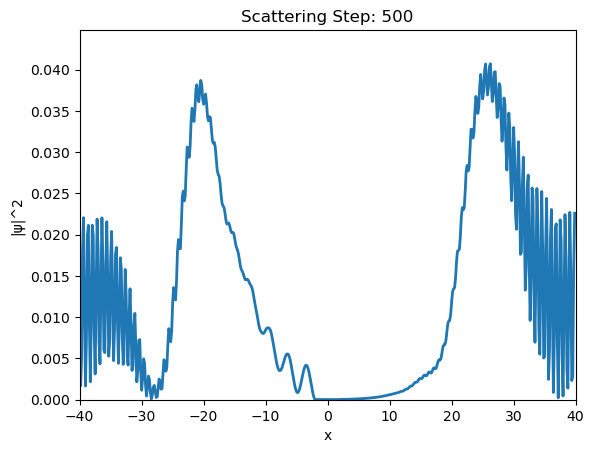

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation

###############################################################################
# 1. Physical / Numerical Parameters
###############################################################################
ħ       = 1.0      # Reduced Planck's constant (units)
m       = 1.0      # Particle mass (units)
Nx      = 512      # Number of spatial grid points
x_min   = -40.0
x_max   =  40.0
L       = x_max - x_min
dx      = L / Nx

dt      = 0.025     # Time step
n_steps = 500     # Number of time steps
plot_every = 1   # Store/plot wavefunction every 'plot_every' steps

###############################################################################
# 2. Construct spatial and momentum grids
###############################################################################
x = np.linspace(x_min, x_max, Nx, endpoint=False)
dk = 2.0 * np.pi / L

# Create wave-number array:
#   indices 0..(Nx/2) increasing positive wavenumbers, 
#   indices (Nx/2+1).. Nx-1 negative wavenumbers, etc.
k_vals = np.fft.fftfreq(Nx, d=dx) * 2.0 * np.pi

###############################################################################
# 3. Define the Finite Square Well
###############################################################################
def finite_square_well(x, left_edge, right_edge, V0):
    """
    Returns a 1D potential array with a 'square well' from [left_edge, right_edge]
    of depth -V0 (i.e. negative potential).
    """
    V = np.zeros_like(x)
    mask = (x >= left_edge) & (x <= right_edge)
    V[mask] = -V0
    return V

V0         = 50.0    # well depth
well_left  = -2.0
well_right =  2.0
V = finite_square_well(x, well_left, well_right, V0)

###############################################################################
# 4. Initial Gaussian Wave Packet
###############################################################################
x0    = -15.0   # initial center
sigma = 1.0
k0    = 3.0     # wave number -> momentum p = ħ*k0

def initial_gaussian_packet(x, x0, sigma, k0):
    """
    Returns a Gaussian wave packet centered at x0,
    with standard dev sigma, plane-wave factor e^{i k0 x}.
    """
    # Normalization factor is flexible; for large domains, we can skip it 
    # or just do approximate normalization.
    norm_factor = 1.0 / (np.sqrt(sigma * np.sqrt(np.pi)))
    return norm_factor * np.exp(-0.5 * ((x - x0)/sigma)**2) * np.exp(1j * k0 * x)

psi = initial_gaussian_packet(x, x0, sigma, k0)

###############################################################################
# 5. Split-Operator Step
###############################################################################
def split_operator_step(psi, V, dt, k_vals):
    """
    Performs one Strang-split time step:
      1) half-step kinetic
      2) full-step potential
      3) half-step kinetic
    psi     : current wavefunction in real space
    V       : potential array
    dt      : time step
    k_vals  : array of wave numbers
    """
    # 1) Half-step in kinetic (momentum) space
    psi_k = np.fft.fft(psi)
    # E_kin(k) = ħ^2 * k^2 / (2m)
    E_kin = (ħ**2 * k_vals**2) / (2.0 * m)
    # multiply by exp(-i E_kin dt/(2ħ))
    psi_k *= np.exp(-0.5j * E_kin * dt / ħ)
    psi = np.fft.ifft(psi_k)

    # 2) Full-step in potential (real) space
    # multiply by exp(-i V dt / ħ)
    psi *= np.exp(-1j * V * dt / ħ)

    # 3) Another half-step in kinetic
    psi_k = np.fft.fft(psi)
    psi_k *= np.exp(-0.5j * E_kin * dt / ħ)
    psi = np.fft.ifft(psi_k)

    return psi

###############################################################################
# 6. Main Time Loop
###############################################################################
snapshots = []
snapshots.append(psi.copy())  # store initial wavefunction

for step in range(1, n_steps + 1):
    psi = split_operator_step(psi, V, dt, k_vals)

    # Optionally check or normalize wavefunction:
    # norm_psi = np.sum(np.abs(psi)**2)*dx
    # psi /= np.sqrt(norm_psi)

    if step % plot_every == 0:
        snapshots.append(psi.copy())

###############################################################################
# 7. Animate / Save GIF
###############################################################################
# We'll use matplotlib.animation.FuncAnimation

fig, ax = plt.subplots()
line, = ax.plot(x, np.abs(snapshots[0])**2, lw=2)
ax.set_xlim(x_min, x_max)
ax.set_ylim(0, 1.1 * np.max(np.abs(snapshots[0])**2))
ax.set_xlabel("x")
ax.set_ylabel("|ψ|^2")

def update(frame):
    # frame is an index into snapshots
    psi_current = snapshots[frame]
    prob_density = np.abs(psi_current)**2
    line.set_ydata(prob_density)

    ax.set_ylim(0, 1.1 * np.max(prob_density))
    ax.set_title(f"Scattering Step: {frame*plot_every}")
    return line,

from matplotlib.animation import FuncAnimation

ani = FuncAnimation(fig, update, frames=len(snapshots), blit=False, interval=100)

# Save as GIF (requires "pillow" or "imagemagick" installed)
ani.save("wavefunction_scattering_2.gif", writer="pillow", fps=20)

plt.show()


<img src="wavefunction_scattering_2.gif"></img>